In [1]:
#import
import os
import sys

import tqdm
import math
import torch
import logging

import numpy as np
import pandas as pd
import torch.nn as nn
import lightning.pytorch as pl
import matplotlib.pyplot as plt

from scipy import spatial
from scipy.stats import chisquare, kstest
from scipy.optimize import curve_fit
from torchmetrics import MeanAbsoluteError
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import Callback, LearningRateMonitor, ModelCheckpoint

In [2]:
#model
hyperparams_dict = {
        'energy': 5.754,
        'scale_data': False,
        'augment': False,
        'add_abc': False,
        'abc_loss_factor': 1,
        'augment_factor': 20,
        'test_size': 0.1,
        'batch_size': 256,
        'net_architecture': [5,60,80,100,120,140,240,340,440,640,2000,1040,640,340,240,140,100,80,60,20,1],
        'activation_function': nn.ReLU(),
        'loss_func': 'RMSELoss()',
        'optim_func': torch.optim.Adam,
        'max_epochs': 2000,
        'es_min_delta': 0.00001,
        'es_patience': 50,
        'lr': 0.001,
        'lr_factor':0.5,
        'lr_patience': 5,
        'lr_cooldown': 20,
    }

if True:
    class RMSELoss(torch.nn.Module):
        def __init__(self, add_abc=False):
            super(RMSELoss,self).__init__()
            self.add_abc = add_abc

        @staticmethod
        def func_cos(x, a, b, c):
            return a + b*torch.cos(2*x) + c*torch.cos(x)

        def forward(self, x, y_hat, y, w, A, B, C):
            if self.add_abc:
                phi = x[:, 4]
                criterion = torch.sqrt(torch.mean(w*(y_hat - y)**2)/torch.sum(w)) + \
                            torch.mul(hyperparams_dict.get('abc_loss_factor'), torch.mean(torch.abs(w*y - self.func_cos(phi,A,B,C)))/torch.sum(w))
            else:
                criterion = torch.sqrt(torch.mean(w * (y_hat - y) ** 2) / torch.sum(w))
            return criterion

    #params
    project_name = "MSU_interpol_unified_notebooks"

    logger_path = './wandb_local_logs'
    data_path = './data/clasdb_pi_plus_n.txt'


    logger_full_path = os.path.join(logger_path, project_name, 'spring-feather-42')

    os.makedirs(logger_full_path, exist_ok=True)
    logging.basicConfig(encoding='utf-8',
                        level=logging.DEBUG,
                        format='%(asctime)s : %(levelname)s : %(message)s',
                        handlers=[logging.FileHandler(os.path.join(logger_full_path, 'logs.log'), mode='w'),
                                  logging.StreamHandler(sys.stdout)],
                        force=True)

    class InterpolDataSet(Dataset):
        def __init__(self, features, labels, weights):
            self.features = features
            self.labels = labels
            self.weights = weights
            self.len = len(labels)

        def __getitem__(self, index):
            feature = self.features[index]
            label = self.labels[index]
            weights = self.weights[index]
            return feature, label, weights

        def __len__(self):
            return self.len

    class InterpolDataModule(pl.LightningDataModule):
        def __init__(self, hyperparams):
            super().__init__()
            self.df = None
            self.hyperparams = hyperparams
            self.train_dataset = None
            self.val_dataset = None

        def augment(self, new_augm):
            augm = pd.Series({'Ebeam': np.random.normal(loc=new_augm.Ebeam, scale=new_augm.Ebeam/30),
                               'W': np.random.normal(loc=new_augm.W, scale=new_augm.W/30),
                               'Q2': np.random.normal(loc=new_augm.Q2, scale=new_augm.Q2/30),
                               'cos_theta': np.clip(np.random.normal(loc=new_augm.cos_theta, scale=abs(new_augm.cos_theta/30)), -1, 1),
                               'phi': np.clip(np.random.normal(loc=new_augm.phi, scale=new_augm.phi/30), 0, 2*np.pi),
                               'dsigma_dOmega': np.random.normal(loc=new_augm.dsigma_dOmega, scale=new_augm.error/3),
                               'error': new_augm.error,
                               'weight': new_augm.weight,
                              })
            return augm

        def setup(self, stage):
            # data reading and preprocessing
            df = pd.read_csv(data_path, delimiter='\t', header=None)
            df.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
            df.loc[8314:65671, 'Ebeam'] = 5.754  # peculiarity of this dataset.
            df = df[~((df.Ebeam == 5.754) & (~df.Q2.isin([1.715, 2.050, 2.445, 2.915, 3.480, 4.155])))] # peculiarity of this dataset #2
            df['phi'] = df.phi.apply(lambda x: math.radians(x))
            df['weight'] = df['error'].apply(lambda x: x and 1 / x or 100)  # x and 1 / x or 100  is just a reversed error but with validation 1/0 error in this case it will return 100
            df = df.drop('id', axis=1)
            df = df.drop_duplicates(subset=['Ebeam', 'W', 'Q2', 'cos_theta', 'phi'])
    
            df = df[df.Ebeam==hyperparams_dict.get('energy')]
    
            # #train test split
            feature_columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']
    
            df['A'] = None
            df['B'] = None
            df['C'] = None
            feature_columns_with_additional = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'weight', 'A', 'B', 'C']
    
            if self.hyperparams.get('add_abc'):
                for Ebeam in df.Ebeam.unique():
                    for Q2 in tqdm.tqdm(df[df.Ebeam == Ebeam].Q2.unique(), desc='ABC Q cycle'):
                        for W in df[(df.Ebeam == Ebeam) & (df.Q2 == Q2)].W.unique():
                            for cos_theta in df[(df.Ebeam == Ebeam) & (df.Q2 == Q2) & (df.W == W)].cos_theta.unique():
                                try:
                                    if df.loc[(df.Ebeam == Ebeam) & (df.Q2 == Q2) & (df.W == W) & (
                                            df.cos_theta == cos_theta), 'A'].iloc[0] is None:
                                        A, B, C = self.get_abc(df, Ebeam, Q2, W, cos_theta)
                                        df.loc[(df.Ebeam == Ebeam) & (df.Q2 == Q2) & (df.W == W) & (
                                                df.cos_theta == cos_theta), 'A'] = A
                                        df.loc[(df.Ebeam == Ebeam) & (df.Q2 == Q2) & (df.W == W) & (
                                                df.cos_theta == cos_theta), 'B'] = B
                                        df.loc[(df.Ebeam == Ebeam) & (df.Q2 == Q2) & (df.W == W) & (
                                                df.cos_theta == cos_theta), 'C'] = C
                                    else:
                                        pass
                                except Exception as e:
                                    df.loc[(df.Ebeam == Ebeam) & (df.Q2 == Q2) & (df.W == W) & (
                                            df.cos_theta == cos_theta), 'A'] = 0
                                    df.loc[(df.Ebeam == Ebeam) & (df.Q2 == Q2) & (df.W == W) & (
                                            df.cos_theta == cos_theta), 'B'] = 0
                                    df.loc[(df.Ebeam == Ebeam) & (df.Q2 == Q2) & (df.W == W) & (
                                            df.cos_theta == cos_theta), 'C'] = 0
            else:
                pass
    
            feature_data = df[feature_columns_with_additional]
            label_data = df['dsigma_dOmega']
    
            if self.hyperparams.get('scale_data'):
                scaler_feature = StandardScaler()
                scaler_target = StandardScaler()
                feature_data = scaler_feature.fit_transform(feature_data)
                label_data = scaler_target.fit_transform(label_data.values.reshape(-1, 1))
            else:
                pass
    
            if self.hyperparams.get('augment'):
                aug_series_list = []
                for i in tqdm.tqdm(df.itertuples()):
                    for _ in range(self.hyperparams.get('augment_factor')):
                        aug_series_list.append(self.augment(i))
    
                aug_df = pd.DataFrame(aug_series_list)
                df = pd.concat([df, aug_df])
            else:
                pass
    
            self.df = df
    
            train_feature_data, val_feature_data, train_label_data, val_label_data = train_test_split(feature_data,
                                                                                                      label_data,
                                                                                                      test_size=self.hyperparams.get(
                                                                                                          'test_size'),
                                                                                                      random_state=1438)
    
            self.train_dataset = InterpolDataSet(
                torch.tensor(train_feature_data[feature_columns].values, dtype=torch.float32),
                torch.tensor(train_label_data.values, dtype=torch.float32),
                torch.tensor(train_feature_data['weight'].values, dtype=torch.float32))
    
            self.val_dataset = InterpolDataSet(torch.tensor(val_feature_data[feature_columns].values, dtype=torch.float32),
                                               torch.tensor(val_label_data.values, dtype=torch.float32),
                                               torch.tensor(val_feature_data['weight'].values, dtype=torch.float32))
            
        def train_dataloader(self):
            return DataLoader(dataset = self.train_dataset, batch_size = self.hyperparams.get('batch_size'), shuffle = False, num_workers=0)

        def val_dataloader(self):
            return DataLoader(dataset = self.val_dataset, batch_size = self.hyperparams.get('batch_size'), shuffle = False, num_workers=0)

    class PrintCallbacks(Callback):
        def on_train_start(self, trainer, pl_module):
            logging.info("Training is starting")

        def on_train_end(self, trainer, pl_module):
            logging.info("Training is ending")

        def on_train_epoch_end(self, trainer, pl_module):
            epoch_mean = torch.stack(pl_module.training_step_outputs).mean()
            logging.info(f"epoch: {pl_module.current_epoch}; train_loss: {epoch_mean}")
            pl_module.training_step_outputs.clear()

        def on_validation_epoch_end(self, trainer, pl_module):
            epoch_mean = torch.stack(pl_module.validation_step_outputs).mean()
            logging.info(f"epoch: {pl_module.current_epoch}; val_loss: {epoch_mean}")
            pl_module.validation_step_outputs.clear()

    class InterpolRegressor(pl.LightningModule):
        def __init__(self, hyperparams):
            super(InterpolRegressor, self).__init__()

            self.train_loss, self.train_mae, self.val_loss, self.val_mae = 0,0,0,0
            self.hyperparams = hyperparams
            self.save_hyperparameters(self.hyperparams)

            self.mae = MeanAbsoluteError()
            self.loss_func = self.hyperparams.get('loss_func')

            self.optim = self.hyperparams.get('optim_func')

            self.net_architecture = self.hyperparams.get('net_architecture')
            self.activation_function = self.hyperparams.get('activation_function')

            self.training_step_outputs = []
            self.validation_step_outputs = []

            self.net = nn.Sequential()
            for i in range(1,len(self.net_architecture)):
                self.net.append(nn.Linear(self.net_architecture[i-1], self.net_architecture[i]))
                if i!=len(self.net_architecture)-1:
                    self.net.append(self.activation_function)
                else:
                    pass

        def forward(self, x):
            return self.net(x)

        def training_step(self, batch, batch_idx):
            x, y, w = batch
            y_hat = self.forward(x)

            loss = self.loss_func
            self.train_loss = loss.forward(y_hat.reshape(-1), y, w)
            self.train_mae = self.mae(y_hat.reshape(-1), y)

            self.log('train_loss', self.train_loss, batch_size=self.hyperparams['batch_size'],
                     on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
            self.log('train_mae', self.train_mae, batch_size=self.hyperparams['batch_size'],
                     on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

            self.training_step_outputs.append(self.train_loss)
            return self.train_loss

        def validation_step(self, batch, batch_idx):
            x, y, w = batch
            y_hat = self.forward(x)

            loss = self.loss_func
            self.val_loss = loss.forward(y_hat.reshape(-1), y, w)
            self.val_mae = self.mae(y_hat.reshape(-1), y)

            self.log('val_loss', self.val_loss, batch_size=self.hyperparams['batch_size'],
                     on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
            self.log('val_mae', self.val_mae, batch_size=self.hyperparams['batch_size'],
                     on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

            self.validation_step_outputs.append(self.val_loss)
            return self.val_loss

        def on_validation_epoch_end(self):
            sch = self.lr_schedulers()
            if isinstance(sch, torch.optim.lr_scheduler.ReduceLROnPlateau) and self.trainer.current_epoch!=0:
                    sch.step(self.trainer.callback_metrics["val_loss"])

        def configure_callbacks(self):
            early_stop_callback = EarlyStopping(monitor="val_loss", mode="min",
                                                min_delta=self.hyperparams.get('es_min_delta'),
                                                patience=self.hyperparams.get('es_patience'),
                                                verbose=True)

            checkpoint_callback = ModelCheckpoint(save_top_k=3,
                                                  monitor="val_loss",
                                                  mode="min",
                                                  dirpath=f"{logger_full_path}/checkpoints",
                                                  filename="{exp_name}{val_loss:.5f}-{epoch:02d}")

            lr_monitor = LearningRateMonitor(logging_interval='epoch')

            print_callback = PrintCallbacks()

            return [early_stop_callback, checkpoint_callback, print_callback, lr_monitor]

        def configure_optimizers(self):
            optimizer = self.optim(self.parameters(), lr=self.hyperparams.get('lr'))
            lr_optim = ReduceLROnPlateau(optimizer = optimizer,
                                         mode = 'min',
                                         factor = self.hyperparams.get('lr_factor'),
                                         patience = self.hyperparams.get('lr_patience'),
                                         cooldown=self.hyperparams.get('lr_cooldown'),
                                         threshold=0.01,
                                         verbose= True)
            return {"optimizer": optimizer,
                    "lr_scheduler": {
                        "scheduler": lr_optim,
                        "interval": "epoch",
                        "monitor": "val_loss",
                        "frequency": 2,
                        "name": 'lr_scheduler_monitoring'}
                    }

    data = InterpolDataModule(hyperparams_dict)
    data.setup('test')
    df = data.df
    df_all = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']]
    df_target = df[['dsigma_dOmega']]

In [3]:
model = InterpolRegressor.load_from_checkpoint(f'./data/models/generous-eon-24/checkpoints/exp_name=0val_loss=0.08709-epoch=141.ckpt', hyperparams=hyperparams_dict)
model.eval()
type(model)

2024-11-01 21:24:30,375 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/data/models/generous-eon-24/checkpoints/exp_name=0val_loss=0.08709-epoch=141.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.11/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.


__main__.InterpolRegressor

In [4]:
df = pd.read_csv(data_path, delimiter='\t', header=None)
df.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
df.loc[8314:65671, 'Ebeam'] = 5.754  # peculiarity of this dataset.
df = df[~((df.Ebeam == 5.754) & (~df.Q2.isin([1.715, 2.050, 2.445, 2.915, 3.480, 4.155])))] # peculiarity of this dataset #2
df['phi'] = df.phi.apply(lambda x: math.radians(x))
df['weight'] = df['error'].apply(lambda x: x and 1 / x or 100)  # x and 1 / x or 100  is just a reversed error but with validation 1/0 error in this case it will return 100
df = df.drop('id', axis=1)
df = df.drop_duplicates(subset=['Ebeam', 'W', 'Q2', 'cos_theta', 'phi'])

2024-11-01 21:24:30,496 : DEBUG : Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-11-01 21:24:30,497 : DEBUG : Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-11-01 21:24:30,498 : DEBUG : findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-11-01 21:24:30,499 : DEBUG : findfont: score(FontEntry(fname='/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.11/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-11-01 21:24:30,499 : DEBUG : findfont: score(FontEntry(fname='/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.11/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal'

Text(0, 0.5, 'Q^2, GeV^2')

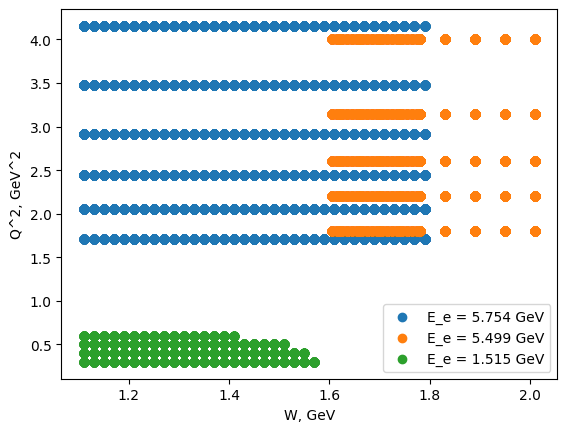

In [5]:
#df[(df.Ebeam==5.754)&(df.Q2==1.715)&(df.W==1.23)]

plt.scatter(df[df.Ebeam==5.754].W, df[df.Ebeam==5.754].Q2, label='E_e = 5.754 GeV')
plt.scatter(df[df.Ebeam==5.499].W, df[df.Ebeam==5.499].Q2, label='E_e = 5.499 GeV')
plt.scatter(df[df.Ebeam==1.515].W, df[df.Ebeam==1.515].Q2, label='E_e = 1.515 GeV')
plt.legend()
plt.xlabel('W, GeV')
plt.ylabel('Q^2, GeV^2')

# Cross sections

In [27]:
df_grid = pd.read_csv('./data/bootstrap_csv_5754.csv')

df_grid['dsigma_dOmega_predicted'] = df_grid.apply(lambda x: np.mean([x[f'dsigma_dOmega_predicted_{i}'] for i in range(23,43) if i!=30]), axis=1)
df_grid['A'] = df_grid.apply(lambda x: np.mean([x[f'A_{i}'] for i in range(23,43) if i!=30]), axis=1)
df_grid['B'] = df_grid.apply(lambda x: np.mean([x[f'B_{i}'] for i in range(23,43) if i!=30]), axis=1)
df_grid['C'] = df_grid.apply(lambda x: np.mean([x[f'C_{i}'] for i in range(23,43) if i!=30]), axis=1)
df_grid['dsigma_dOmega_sf'] = df_grid.apply(lambda x: np.mean([x[f'dsigma_dOmega_sf_{i}'] for i in range(23,43) if i!=30]), axis=1)

df_grid['dsigma_dOmega_predicted_std'] = df_grid.apply(lambda x: np.std([x[f'dsigma_dOmega_predicted_{i}'] for i in range(23,43) if i!=30]), axis=1)
df_grid['A_std'] = df_grid.apply(lambda x: np.std([x[f'A_{i}'] for i in range(23,43) if i!=30]), axis=1)
df_grid['B_std'] = df_grid.apply(lambda x: np.std([x[f'B_{i}'] for i in range(23,43) if i!=30]), axis=1)
df_grid['C_std'] = df_grid.apply(lambda x: np.std([x[f'C_{i}'] for i in range(23,43) if i!=30]), axis=1)
df_grid['dsigma_dOmega_sf_std'] = df_grid.apply(lambda x: np.std([x[f'dsigma_dOmega_sf_{i}'] for i in range(23,43) if i!=30]), axis=1)

KeyError: 'dsigma_dOmega_predicted_23'

In [5]:
# df_grid[['Ebeam',
#         'W',
#         'Q2',
#         'cos_theta',
#         'phi',
#         'dsigma_dOmega_predicted',
#         'A',
#         'B',
#         'C',
#         'dsigma_dOmega_sf',
#         'dsigma_dOmega_predicted_std',
#         'A_std',
#         'B_std',
#         'C_std',
#         'dsigma_dOmega_sf_std']].to_csv('./data/bootstrap_csv_5499_std.csv', index=False)

In [15]:
df_grid = pd.read_csv('./data/bootstrap_csv_5754_std.csv')

In [16]:
df_grid = df_grid[['Ebeam',
                    'W',
                    'Q2',
                    'cos_theta',
                    'phi',
                    'dsigma_dOmega_predicted',
                    'A',
                    'B',
                    'C',
                    'dsigma_dOmega_sf',
                    'dsigma_dOmega_predicted_std',
                    'A_std',
                    'B_std',
                    'C_std',
                    'dsigma_dOmega_sf_std']]

In [14]:
# generate grid
if True:
    Ebeam = hyperparams_dict.get('energy')
    step_W = 0.005
    step_Q2 = 0.1
    step_cos_theta = 0.1
    step_phi = 0.05

    W_min = df[df.Ebeam==Ebeam].W.min() - 0.1
    W_max = df[df.Ebeam==Ebeam].W.max() + 0.1 + step_W

    Q2_min = df[df.Ebeam==Ebeam].Q2.min() - 0.1
    Q2_max = df[df.Ebeam==Ebeam].Q2.max() + 0.1 + step_Q2

    data_grid = []
    for W in tqdm.tqdm(np.arange(W_min, W_max, step_W)):
        for Q2 in np.arange(Q2_min, Q2_max, step_Q2):
             for cos_theta in np.arange(-1, 1+step_cos_theta, step_cos_theta):
                    for phi in np.arange(0, 2*np.pi, step_phi):
                        data_grid.append([Ebeam,W,Q2,cos_theta,phi])

    df_grid = pd.DataFrame(data_grid)
    df_grid.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']

    df_grid.W = np.round(df_grid.W, 3)
    df_grid.Q2 = np.round(df_grid.Q2, 3)
    df_grid.cos_theta = np.round(df_grid.cos_theta, 3)
    df_grid.phi = np.round(df_grid.phi, 3)

 60%|█████▉    | 106/177 [00:03<00:01, 35.52it/s]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x103a24f10>>
Traceback (most recent call last):
  File "/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.11/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
100%|██████████| 177/177 [00:05<00:00, 32.40it/s]


In [39]:
# predict crosssections
if True:
    df_grid_parts = np.array_split(df_grid, 100)
    df_grid_parts_preds = []
    for df_grid_part in tqdm.tqdm(df_grid_parts):
        dsigma_dOmega_predicted = model.forward(torch.tensor(df_grid_part.to_numpy(),dtype=torch.float32)).detach()

        df_grid_part['dsigma_dOmega_predicted'] = dsigma_dOmega_predicted
        df_grid_part.dsigma_dOmega_predicted = abs(df_grid_part.dsigma_dOmega_predicted)

        df_grid_part['A'] = 0
        df_grid_part['B'] = 0
        df_grid_part['C'] = 0
        df_grid_parts_preds.append(df_grid_part)

    df_grid = pd.concat(df_grid_parts_preds)

/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
100%|██████████| 100/100 [03:04<00:00,  1.84s/it]


In [40]:
# calculate structure functions
if True:
    phi_min_index = df_grid[df_grid.phi == df_grid.phi.min()].index.to_numpy()
    phi_max_index = df_grid[df_grid.phi == df_grid.phi.max()].index.to_numpy()

    for i in tqdm.tqdm(range(len(phi_min_index))):
        cross_section_chunk = df_grid.iloc[phi_min_index[i]:phi_max_index[i]].dsigma_dOmega_predicted
        cos_phi = np.cos(df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)
        cos_2_phi = np.cos(2*df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)

        trapz_A = np.trapz(cross_section_chunk, dx=step_phi)
        trapz_B = np.trapz(cross_section_chunk*cos_2_phi, dx=step_phi)
        trapz_C = np.trapz(cross_section_chunk*cos_phi, dx=step_phi)

        A = trapz_A/(2*np.pi)
        B = trapz_B/(np.pi)
        C = trapz_C/(np.pi)

        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'C'] = C

  0%|          | 0/104076 [00:00<?, ?it/s]/var/folders/tj/2cbzjkv53dj9l4yrll73xw400000gq/T/ipykernel_29150/1944332864.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.08704312444086548' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
/var/folders/tj/2cbzjkv53dj9l4yrll73xw400000gq/T/ipykernel_29150/1944332864.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.05031026182844206' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
/var/folders/tj/2cbzjkv53dj9l4yrll73xw400000gq/T/ipykernel_29150/1944332864.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pand

In [73]:
df_grid['dsigma_dOmega_sf'] = df_grid['A'] + df_grid['B']*np.cos(2*df_grid['phi']) + df_grid['C']*np.cos(df_grid['phi'])
df = df.drop_duplicates(['Ebeam', 'W', 'Q2', 'cos_theta', 'phi'])

In [9]:
def find_closest(df_for_search, W_for_search, Q2_for_search):
    global closest_index
    closest_index = df_for_search[['W', 'Q2']].drop_duplicates(). \
                    apply(lambda x: spatial.distance.euclidean([W_for_search, Q2_for_search], [x.W, x.Q2]), axis=1).idxmin() 
    assert isinstance(closest_index, tuple([int, np.int64])) 
    return (df_for_search.loc[closest_index, 'W'], df_for_search.loc[closest_index, 'Q2'])
def plot_joint_cross_sections(df, E_beam, W, Q2, cos_theta, df_grid):
    W_df, Q2_df = find_closest(df, W, Q2)
    W_df_grid, Q2_df_grid = find_closest(df_grid, W, Q2)
    
    df_instance_set = df[(df.Ebeam == E_beam)&
                        (df.W == W_df)&
                        (df.Q2 == Q2_df)&
                        (df.cos_theta == cos_theta)].sort_values('phi')

    df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.W == W_df_grid)&
                                    (df_grid.Q2 == Q2_df_grid)&
                                    (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('phi')
 
            
    if len(df_instance_set)==0:
        print(len(df_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_instance_set)==0')

    if len(df_grid_instance_set)==0:
        print(len(df_grid_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_grid_instance_set)==0')

    def func_cos(x, a, b, c):
        return a + b*np.cos(2*x) + c*np.cos(x)

    #input data
    xdata_real = df_instance_set.phi
    ydata_real = df_instance_set.dsigma_dOmega
    ydata_error_real = df_instance_set.error
    
    xdata_preds = df_grid_instance_set.phi
    ydata_preds = df_grid_instance_set.dsigma_dOmega_predicted
    ydata_preds_std = df_grid_instance_set.dsigma_dOmega_predicted_std

    xdata_preds_sf = xdata_preds
    ydata_preds_sf = df_grid_instance_set.dsigma_dOmega_sf
    ydata_preds_sf_std = df_grid_instance_set.dsigma_dOmega_sf_std

    #fitting the data
    popt, pcov = curve_fit(func_cos, xdata_real, ydata_real, sigma=ydata_error_real, absolute_sigma=True)
    a, b, c = popt[0], popt[1], popt[2]

    # recovered

    xdata_fitted = [i for i in np.arange(0, 2*np.pi, 0.01)]
    ydata_fitted = [func_cos(x, a, b, c) for x in xdata_fitted]
    
    df_fitted = pd.DataFrame({'phi_fitted': xdata_fitted,
                              'dsigma_dOmega_fitted': ydata_fitted})
    
    df_chi_2 = pd.merge_asof(df_instance_set, df_fitted, left_on='phi', right_on='phi_fitted')
    df_chi_2 = pd.merge_asof(df_chi_2, df_grid_instance_set, on='phi')
    df_chi_2 = df_chi_2[['phi', 'dsigma_dOmega', 'dsigma_dOmega_fitted', 'dsigma_dOmega_predicted', 'dsigma_dOmega_sf']]

    real = df_chi_2['dsigma_dOmega'].apply(lambda x: np.round(x, 6)).values
    fitted = df_chi_2['dsigma_dOmega_fitted'].apply(lambda x: np.round(x, 6)).values
    preds = df_chi_2['dsigma_dOmega_predicted'].apply(lambda x: np.round(x, 6)).values
    preds_sf = df_chi_2['dsigma_dOmega_sf'].apply(lambda x: np.round(x, 6)).values
    
    stat_fitted_chi, p_value_fitted_chi = np.round(chisquare(real, np.sum(real)/np.sum(fitted)*fitted), 3)
    stat_preds_chi, p_value_preds_chi = np.round(chisquare(real, np.sum(real)/np.sum(preds)*preds), 3)
    stat_preds_sf_chi, p_value_preds_sf_chi = np.round(chisquare(real, np.sum(real)/np.sum(preds_sf)*preds_sf), 3)
    plt.figure(figsize=(22, 6), dpi=80)
    # plt.figtext(0.13, 0.83, f'Params (exp, preds). W({W_df},{W_df_grid}); Q2({Q2_df},{Q2_df_grid})')
    
    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                color='red', marker='*', label=f"Experimental data")
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_error_real,
                 color='red',
                 fmt='o')

    plt.plot(xdata_fitted,
             ydata_fitted,
             color='blue',
             label=f'Fitted data'
             # label=f'Fitted data, chi^2 = {stat_fitted_chi}, p_value = {p_value_fitted_chi}'
             )

    plt.plot(xdata_preds,
             ydata_preds,
             color='green',
             label=f'Predicted data'
             # label=f'Predicted data, chi^2 = {stat_preds_chi}, p_value = {p_value_preds_chi}'
             )
    plt.fill_between(xdata_preds, ydata_preds-ydata_preds_std, ydata_preds+ydata_preds_std, color='green', alpha=0.4)

    # plt.plot(xdata_preds_sf,
    #          ydata_preds_sf,
    #          color='black',
    #          label=f'Computed from the predicted phi moments'
    #          # label=f'Predictions and recovered data, chi^2 = {stat_preds_sf_chi}, p_value = {p_value_preds_sf_chi}'
    #          )
    # plt.fill_between(xdata_preds_sf, ydata_preds_sf-ydata_preds_sf_std, ydata_preds_sf+ydata_preds_sf_std, color='black', alpha=0.4)

    plt.ylim(ymin=0)
    plt.xlim(xmin=0, xmax=2*np.pi)

    plt.xlabel("phi: rad", fontsize="20")
    plt.ylabel("dsigma/dOmega: microbarn/sterad", fontsize="20")

    plt.tick_params(axis='both', which='major', labelsize=20)

    plt.title(f"Ebeam: {E_beam} GeV, W: {W} GeV, Q2: {Q2} GeV^2, cos_theta: {cos_theta} rad", fontsize="30")
    plt.legend(loc ="upper right", fontsize="15",  ncol=4, columnspacing=0.8)
    plt.savefig(f'./final_checks_bootstrap_3.0/3_models/cross_sections/E_beam={E_beam}/Q2={Q2}/W={W}/E_beam={E_beam}_Q2={Q2}_W={W}_cos_theta={cos_theta}.png')
    plt.subplots_adjust(left=0.1, right=0.9, top=1.1, bottom=0.1)
    plt.show()
    plt.close()
    return None

In [10]:
df['cos_theta'] = df['cos_theta'].round(1)

In [17]:
plot_joint_cross_sections(df, 5.754, 1.68, 2.915, -1, df_grid)
# plot_joint_cross_sections(df, 5.754, 1.68, 2.915, -0.9, df_grid)
# plot_joint_cross_sections(df, 1.515, 1.23, 0.3, -0.1, df_grid)
# df[(df.Ebeam==1.515)&
#    (df.W==1.23)&
#    (df.Q2==0.3)].cos_theta.unique()
# df[(df.Ebeam==5.754)].W.unique()

0 5.754 1.68 2.915 -1


ValueError: len(df_instance_set)==0

In [38]:
Ebeam = hyperparams_dict['energy']

In [1]:
for Q2 in tqdm.tqdm(df[df.Ebeam==Ebeam].Q2.unique()):
    os.makedirs(f"./final_checks_bootstrap_3.0/3_models/cross_sections/E_beam={Ebeam}/Q2={Q2}")
    for W in tqdm.tqdm([1.23, 1.53, 1.68, 1.95]):
        os.makedirs(f"./final_checks_bootstrap_3.0/3_models/cross_sections/E_beam={Ebeam}/Q2={Q2}/W={W}")
        for cos_theta in [-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
            try:
                plot_joint_cross_sections(df, Ebeam, W, Q2, cos_theta, df_grid)
            except:
                print(Ebeam, W, Q2, cos_theta)

## Structure functions

In [30]:
def func_cos(x, a, b, c):
        return a + b*np.cos(2*x) + c*np.cos(x)

def fit_to_func(x):
    try:
        popt, pcov = curve_fit(func_cos, x.phi, x.dsigma_dOmega, sigma=x.error, absolute_sigma=True)
        a, b, c = popt[0], popt[1], popt[2]
        
        a_error, b_error, c_error = np.sqrt(pcov[0][0]), np.sqrt(pcov[1][1]), np.sqrt(pcov[2][2])
        
        return a, b, c, a_error, b_error, c_error
    except Exception as e:
        return None, None, None, None, None, None
    
df_sf = df.groupby(['Ebeam', 'W', 'Q2', 'cos_theta']).apply(lambda x: fit_to_func(x)).reset_index()

/var/folders/tj/2cbzjkv53dj9l4yrll73xw400000gq/T/ipykernel_2960/473085029.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sf = df.groupby(['Ebeam', 'W', 'Q2', 'cos_theta']).apply(lambda x: fit_to_func(x)).reset_index()


In [31]:
df_sf['A'] = df_sf[0].apply(lambda x: x[0])
df_sf['B'] = df_sf[0].apply(lambda x: x[1])
df_sf['C'] = df_sf[0].apply(lambda x: x[2])

df_sf['A_error'] = df_sf[0].apply(lambda x: x[3])
df_sf['B_error'] = df_sf[0].apply(lambda x: x[4])
df_sf['C_error'] = df_sf[0].apply(lambda x: x[5])

df_sf.drop(0, axis=1, inplace=True)
df_sf.dropna(inplace=True)

In [32]:
df_sf = df_sf[~((df_sf['A_error']>0.7)|(df_sf['B_error']>0.7)|(df_sf['C_error']>0.7))]

In [57]:
def plot_joint_sf(df, E_beam, Q2, cos_theta, df_grid, func, func_error):
    
    W_df, Q2_df = find_closest(df, W, Q2)
    W_df_grid, Q2_df_grid = find_closest(df_grid, W, Q2)
    
    df_instance_set = df[(df.Ebeam == E_beam)&
                        (df.Q2 == Q2)&
                        (df.cos_theta == cos_theta)].sort_values('W')

    df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.Q2 == Q2_df_grid)&
                                    (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('W')
    
    df_grid_instance_set = df_grid_instance_set[(df_grid_instance_set['W']>=df_instance_set.W.min() - 0.2)&
                                                (df_grid_instance_set['W']<=df_instance_set.W.max() + 0.2)&
                                                (df_grid_instance_set['W']>=1.07)]
    
    if len(df_instance_set)==0:
        print(E_beam, Q2, cos_theta)
        raise ValueError('len(df_instance_set)==0')

    if len(df_grid_instance_set)==0:
        print(E_beam, Q2, cos_theta)
        raise ValueError('len(df_grid_instance_set)==0')
    
    xdata_real = df_instance_set.W
    ydata_real = df_instance_set[func]
    ydata_real_error = df_instance_set[func_error]

    xdata_preds = df_grid_instance_set.W
    ydata_preds = df_grid_instance_set[func]
    ydata_preds_std = df_grid_instance_set[f'{func}_std']
    
    plt.figure(figsize=(22, 6), dpi=80)
    
    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                s=100,
                color='red', marker='*', label=f"Fitted data")
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_real_error,
                 color='red',
                 fmt='o')
    
    plt.scatter(x=xdata_preds,
                y=ydata_preds,
                color='black', marker='^', label=f"Predicted data")
    plt.fill_between(xdata_preds, ydata_preds-ydata_preds_std, ydata_preds+ydata_preds_std, color='black', alpha=0.4)
    
    if xdata_preds.min()<1.23:
        plt.axvline(x=1.23, color='blue', label='1st resonance maximum')
    else:
        pass
    if xdata_preds.min()<1.52:
        plt.axvline(x=1.52, color='green', label='2nd resonance maximum')
    else:
        pass
    if xdata_preds.max()>1.68:
        plt.axvline(x=1.68,color='purple', label='3rd resonance maximum')
    else:
        pass
    if xdata_preds.max()>1.92:
        plt.axvline(x=1.92, color='red', label='4th resonance maximum')
    else:
        pass
    
    plt.ylim(ymin=-0.35, ymax=0.35)
    plt.xlim(xmin=1, xmax=2)
    plt.subplots_adjust(left=0.1, right=0.9, top=1.1, bottom=0.1)
    
    plt.xlabel("W: GeV", fontsize="20")
    plt.ylabel(f"{func}: microbarn/sterad", fontsize="20")
    plt.legend(loc ="upper right", fontsize="15",  ncol=6, columnspacing=0.8)
    plt.title(f"Ebeam: {E_beam}, Q2: {Q2}, cos_theta: {cos_theta}", fontsize="30")
    plt.tick_params(axis='both', which='major', labelsize=20)

    plt.savefig(f'./final_checks_bootstrap_3.0/3_models/structure_functions/E_beam={E_beam}/Q2={Q2}/{func}/E_beam={E_beam}_Q2={Q2}_cos_theta={cos_theta}.png')
    plt.show()
    plt.close()
    return None

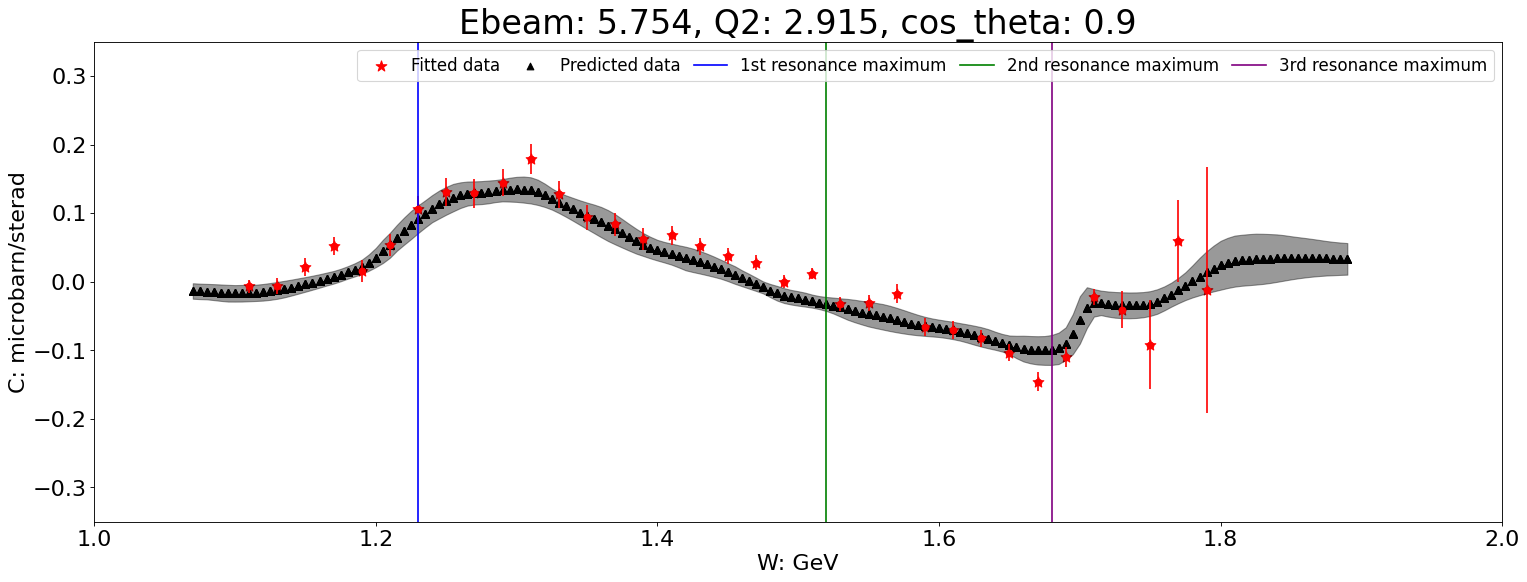

In [60]:
plot_joint_sf(df_sf, 5.754, 2.915, 0.9, df_grid, 'C', 'C_error')

In [ ]:
func, func_error = 'A', 'A_error'
# func, func_error = 'B', 'B_error'
# func, func_error = 'C', 'C_error'

for Q2 in tqdm.tqdm(df[df.Ebeam==Ebeam].Q2.unique()):
    os.makedirs(f"final_checks_bootstrap_3.0/3_models/structure_functions/E_beam={Ebeam}/Q2={Q2}/{func}", exist_ok=True)
    for cos_theta in [-0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, -0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        try:
            plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func, func_error)
        except Exception as e:
            print(Ebeam, Q2, cos_theta)
            print(e)